# Simulation of CNCS powder experiment

In [1]:
# some goodies
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np, histogram.hdf as hh, histogram as H

## Create workflow

In [2]:
# Change me
workdir = "/SNS/users/lj7/simulations/CNCS/powder-demo"
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/simulations/CNCS/powder-demo


In [3]:
rm -rf mysim/

In [4]:
!mcvine workflow powder --instrument=CNCS --sample=V --workdir=mysim

In [5]:
!ls mysim/

beam	    debug-scatter  README.md   sampleassembly  sss	test-scatter
create-nxs  Makefile	   reduce2iqe  scatter	       sss.pml


## Beam simulation

In [6]:
# change to beam sim directory
%cd {workdir}/mysim/beam

/SNS/users/lj7/simulations/CNCS/powder-demo/mysim/beam


In [7]:
# show the simulation script
!cat run-beam.sh

#!/usr/bin/env bash
# run 
#   mcvine instruments cncs beam -h 
# for more options
#
mcvine instruments cncs beam --keep-in-cache --use-cache --ncount=1e8



In [8]:
# modify the simulation script (desired incident energy, neutron count)

In [11]:
%%file run-beam.sh
#!/usr/bin/env bash

mcvine instruments cncs beam -E=50 --ncount=1e8 --nodes=10

Overwriting run-beam.sh


In [13]:
# show the simulation script again
!cat run-beam.sh

#!/usr/bin/env bash

mcvine instruments cncs beam -E=50 --ncount=1e8 --nodes=10

In [14]:
%%time
# run simulation
!./run-beam.sh

 -> running mcvine instruments cncs config_mod2sample --fluxmode=9.0 --f41=300.0 --f2=60.0 --f42=300.0 --Ei=50.0 --f1=60.0 --f3=60.0...
done.
 -> running mcvine instruments cncs mod2sample --moderator.S_filename=/home/lj7/dv/mcvine/resources/instruments/CNCS/mcstas/source_sct21a_td_05_1.dat --buffer_size=2000000 --mpirun.nodes=10 --ncount=100000000.0 --output-dir=_m2sout...
Loading moderator file /home/lj7/dv/mcvine/resources/instruments/CNCS/mcstas/source_sct21a_td_05_1.dat
/home/lj7/dv/mcvine/resources/instruments/CNCS/mcstas/source_sct21a_td_05_1.dat
Loading moderator file /home/lj7/dv/mcvine/resources/instruments/CNCS/mcstas/source_sct21a_td_05_1.dat
/home/lj7/dv/mcvine/resources/instruments/CNCS/mcstas/source_sct21a_td_05_1.dat
Loading moderator file /home/lj7/dv/mcvine/resources/instruments/CNCS/mcstas/source_sct21a_td_05_1.dat
/home/lj7/dv/mcvine/resources/instruments/CNCS/mcstas/source_sct21a_td_05_1.dat
Loading moderator file /home/lj7/dv/mcvine/resources/instruments/CNCS/mcst

After the beam simulation is done
* The main output are in the new folder "out".
* The ".h5" files are histograms of various sorts.
* The "neutron" file is the simulated neutrons of the beam incident on the sample

In [15]:
!ls out

ienergy.h5  ix_divx.h5	ix_y.h5     iy_divy.h5	props.json
itof.h5     ix_divy.h5	iy_divx.h5  neutrons	rank0-step0


<IPython.core.display.Javascript object>


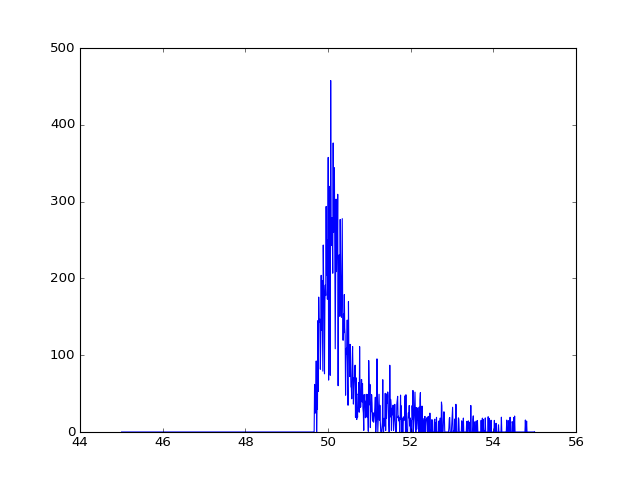

In [16]:
# plot I(E) spectrum
ie = hh.load("out/ienergy.h5")
plt.plot(ie.energy, ie.I)

## Scattering simulation and reduction

The simulation directory contains a Makefile and various scripts to make it easy to run the simulation and analsysis.

In [19]:
%cd {workdir}/mysim
!ls

/SNS/users/lj7/simulations/CNCS/powder-demo/mysim
beam	    debug-scatter  README.md   sampleassembly  sss	test-scatter
create-nxs  Makefile	   reduce2iqe  scatter	       sss.pml


In [20]:
# scatter is the script for sample scattering simulation
!cat scatter

#!/usr/bin/env bash

LAUNCHER=`python -c "from mcni.pyre_support.MpiApplication import mpi_launcher_choice as l; print l"`
rm -rf out && ./sss --ncount=${NCOUNT} --$LAUNCHER.nodes=${NODES} --buffer_size=${BUFFER_SIZE} \
		    --multiple-scattering=off

#--journal.debug.phonon_incoherent_inelastic_kernel


In [21]:
# Change ncount and nodes

In [22]:
%%file scatter
#!/usr/bin/env bash

LAUNCHER=`python -c "from mcni.pyre_support.MpiApplication import mpi_launcher_choice as l; print l"`
rm -rf out && ./sss --ncount=1e7 --multiple-scattering=off --$LAUNCHER.nodes=10 --buffer_size=100000


Overwriting scatter


In [23]:
%%time
# run simulation and reduction
!chmod +x scatter sss reduce2iqe create-nxs
!make

NCOUNT=10000000.0 BUFFER_SIZE=100000 NODES=10 ./scatter </dev/null >log.scatter 2>&1
INSTRUMENT=cncs NODES=10 ./create-nxs </dev/null >log.create-nxs 2>&1
INSTRUMENT=cncs QAXIS="0 15 0.1" ./reduce2iqe >log.reduce 2>&1
CPU times: user 7.75 s, sys: 888 ms, total: 8.64 s
Wall time: 7min 5s


plot z in (0, 1e-07)


<IPython.core.display.Javascript object>


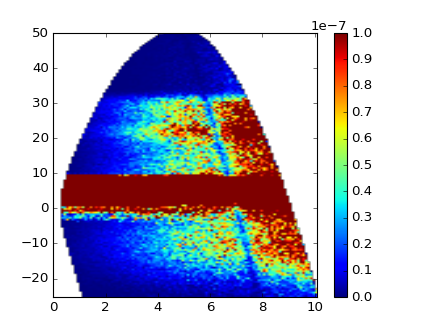

In [27]:
iqe = hh.load("iqe.h5")
H.plot(iqe[(0, 10), ()], min=0, max=1e-7)